In [7]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
import numpy as np
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

In [8]:
import tensorflow as tf
from keras_cv.bounding_box import convert_format

def build_dataset(image_dir, label_dir, batch_size=4, res_scale=1.0, target_format="xywh"):
    imgw = int(1920 * res_scale)
    imgh = int(1080 * res_scale)

    def parse_example(image_path):
        image_path = image_path.numpy().decode("utf-8")
        label_path = image_path.replace(image_dir, label_dir).replace(".png", ".txt")

        # Load and decode image
        img = tf.io.read_file(image_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # normalize to [0, 1]

        # Resize if needed
        if res_scale != 1.0:
            img = tf.image.resize(img, (imgh, imgw))  # TensorFlow uses (height, width)

        # Read YOLO label file
        boxes = []
        classes = []
        with open(label_path, "r") as f:
            for line in f:
                cls, x_c, y_c, w, h = map(float, line.strip().split())
                boxes.append([x_c, y_c, w, h])  # YOLO format: rel_xywh
                classes.append(int(cls))

        # Convert to tensor
        boxes = tf.convert_to_tensor(boxes, dtype=tf.float32)
        classes = tf.convert_to_tensor(classes, dtype=tf.int32)

        # Convert bounding boxes to desired format (e.g. "xywh")
        boxes = convert_format(
            boxes={
                "boxes": boxes,
                "classes": classes
            },
            source="rel_xywh",
            target=target_format,
            images=img
        )["boxes"]

        return img.numpy(), boxes.numpy(), classes.numpy()

    def tf_parse_example(image_path):
        img, boxes, classes = tf.py_function(parse_example, [image_path], [tf.float32, tf.float32, tf.int32])
        img.set_shape((imgh, imgw, 3))
        boxes.set_shape((None, 4))
        classes.set_shape((None,))
        return {
            "images": img,
            "bounding_boxes": {
                "classes": classes,
                "boxes": boxes
            }
        }

    image_paths = tf.data.Dataset.list_files(image_dir + "/*.png", shuffle=True)
    dataset = image_paths.map(tf_parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Usage:
train_ds = build_dataset(
    image_dir="./ds/images/train",
    label_dir="./ds/labels/train",
    res_scale=2,
)

test_ds = build_dataset(
    image_dir="./ds/images/test",
    label_dir="./ds/labels/test",
    res_scale=2
)


2025-07-02 11:21:49.864595: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 398131280 bytes after encountering the first element of size 398131280 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


IndexError: index 3 is out of bounds for axis 0 with size 3

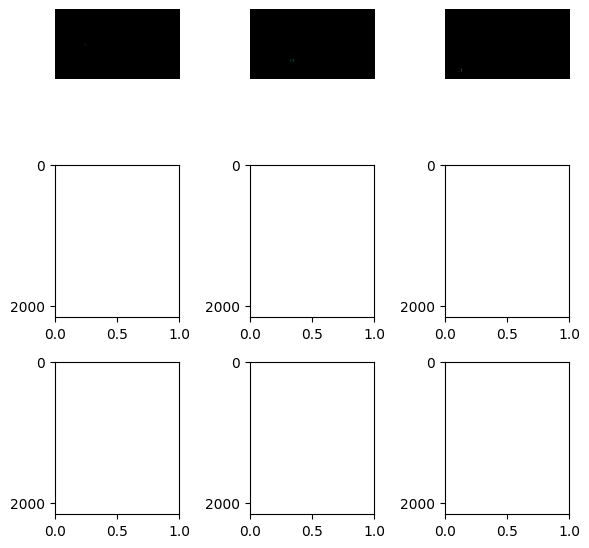

In [9]:
from keras_cv.visualization import plot_bounding_box_gallery
import matplotlib.pyplot as plt


e = next(iter(train_ds.take(1)))

plot_bounding_box_gallery(e['images'], y_true=e['bounding_boxes'], value_range=(0, 255), bounding_box_format = "xywh")
